## Setup

In [56]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [57]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
#task = 'TurnOnLight'
task = 'PressButton'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))


SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
    mask=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.uint8, is_shared=False),
    object_poses=TensorDict(
        fields={
            obj000: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj001: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj002: Tensor(shape=torch.Size([7]), device=cpu, dtype

In [59]:
gt_pose_config = {
    #'indeces': [1,2,3,4],
}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'front',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [60]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([99, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([99]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([99, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([99, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([99, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([99, 3, 256, 256]), device=cpu, dtype=to

In [61]:
tag="release"

tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False, #Use rotation aswell?

    add_gripper_action=True,

    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,

    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,

    trans_cov_mask_t_pos_corr = False,

    em_steps=1,

    fix_first_component=True,
    fix_last_component=True,

    reg_init_diag=5e-4,  # 5

    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.75,
    use_bic=False, #Does prune segmentation

    drop_redundant_frames=True,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    velocity_threshold=0.01,

    repeat_final_step=0,
    repeat_first_step=0,

    components_prop_to_len=True,

    min_n_components=1,
    max_idx_distance=4,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)


In [62]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-04-12 17:37:56.548 | INFO     |          Fitting AutoTPGMM
2025-04-12 17:37:56.549 | INFO     |          Segmenting trajectories


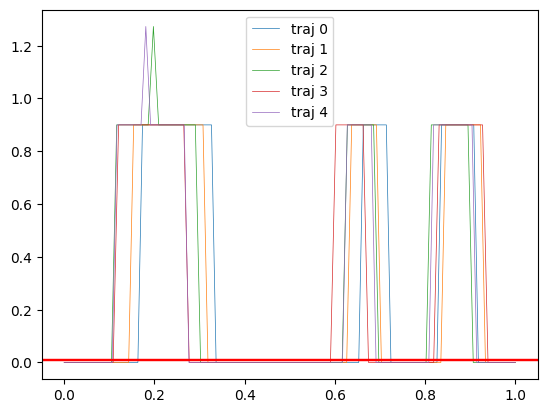

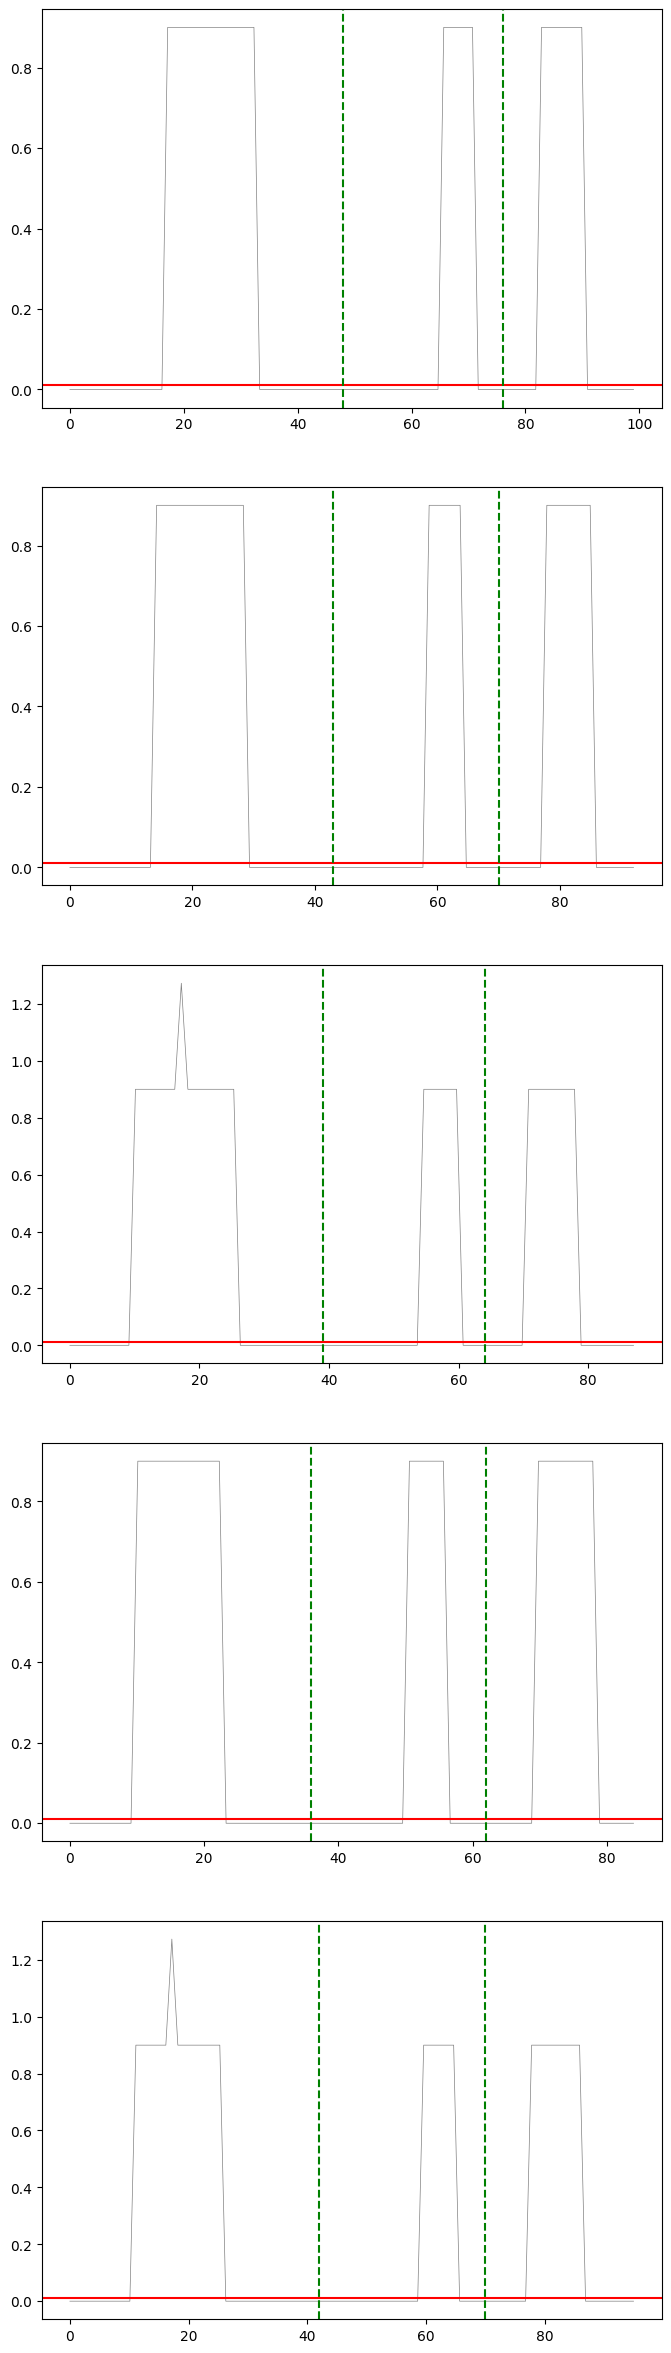

2025-04-12 17:37:57.555 | INFO     |          Creating segement of demos.
2025-04-12 17:37:57.560 | INFO     |          Creating segement of demos.
2025-04-12 17:37:57.565 | INFO     |          Creating segement of demos.
2025-04-12 17:37:57.570 | INFO     |          ... created 3 segments
2025-04-12 17:37:57.571 | INFO     |            Fitting candidate frame 1/10
2025-04-12 17:37:57.571 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-12 17:37:57.902 | INFO     |            Fitting candidate frame 2/10
2025-04-12 17:37:57.902 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-12 17:37:58.467 | INFO     |            Fitting candidate frame 3/10
2025-04-12 17:37:58.468 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-12 17:37:58.959 | INFO     |            Fitting candidate frame 4/10
2025-04-12 17:37:58.960 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-12 17:37:59.487 | INFO     |            Fitting candidate frame 5/10
2025-04-12 17:37:59.488 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-12 17:37:59.900 | INFO     |            Fitting candidate frame 6/10
2025-04-12 17:37:59.901 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-12 17:38:00.540 | INFO     |            Fitting candidate frame 7/10
2025-04-12 17:38:00.541 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-12 17:38:01.047 | INFO     |            Fitting candidate frame 8/10
2025-04-12 17:38:01.048 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-12 17:38:01.570 | INFO     |            Fitting candidate frame 9/10
2025-04-12 17:38:01.571 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-12 17:38:02.045 | INFO     |            Fitting candidate frame 10/10
2025-04-12 17:38:02.045 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2025-04-12 17:38:02.633 | INFO     |          Creating partial frame view of demos.
2025-04-12 17:38:02.636 | INFO     |            Fitting candidate frame 1/10
2025-04-12 17:38:02.636 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:02.891 | INFO     |            Fitting candidate frame 2/10
2025-04-12 17:38:02.892 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:03.172 | INFO     |            Fitting candidate frame 3/10
2025-04-12 17:38:03.173 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:03.475 | INFO     |            Fitting candidate frame 4/10
2025-04-12 17:38:03.476 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:03.906 | INFO     |            Fitting candidate frame 5/10
2025-04-12 17:38:03.908 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:04.205 | INFO     |            Fitting candidate frame 6/10
2025-04-12 17:38:04.206 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:04.464 | INFO     |            Fitting candidate frame 7/10
2025-04-12 17:38:04.465 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:04.627 | INFO     |            Fitting candidate frame 8/10
2025-04-12 17:38:04.628 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:04.873 | INFO     |            Fitting candidate frame 9/10
2025-04-12 17:38:04.874 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:05.135 | INFO     |            Fitting candidate frame 10/10
2025-04-12 17:38:05.136 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:05.430 | INFO     |          Creating partial frame view of demos.
2025-04-12 17:38:05.433 | INFO     |            Fitting candidate frame 1/10
2025-04-12 17:38:05.433 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:05.587 | INFO     |            Fitting candidate frame 2/10
2025-04-12 17:38:05.588 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:05.787 | INFO     |            Fitting candidate frame 3/10
2025-04-12 17:38:05.788 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:06.011 | INFO     |            Fitting candidate frame 4/10
2025-04-12 17:38:06.011 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:06.291 | INFO     |            Fitting candidate frame 5/10
2025-04-12 17:38:06.292 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:06.549 | INFO     |            Fitting candidate frame 6/10
2025-04-12 17:38:06.550 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:06.807 | INFO     |            Fitting candidate frame 7/10
2025-04-12 17:38:06.808 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:07.095 | INFO     |            Fitting candidate frame 8/10
2025-04-12 17:38:07.096 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:07.469 | INFO     |            Fitting candidate frame 9/10
2025-04-12 17:38:07.470 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:07.761 | INFO     |            Fitting candidate frame 10/10
2025-04-12 17:38:07.762 | INFO     |            Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:08.311 | INFO     |          Creating partial frame view of demos.
2025-04-12 17:38:08.329 | INFO     |          Segmented trajs into 3 segments
2025-04-12 17:38:08.372 | INFO     |          Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142857 -0.142857 -0.142857 -0.142857 -0.142857 -0.142857   
Segment 1 -0.142861 -0.142859 -0.142859 -0.142859 -0.142859 -0.142859   
Segment 2 -0.142857 -0.142858 -0.142858 -0.142858 -0.142858 -0.142858   

             obj005        obj006        obj007        obj008  
Segment 0 -0.142857 -4.970898e-07 -2.925433e-08 -1.339366e-07  
Segment 1 -0.142859 -4.616039e-07 -3.442463e-08 -9.856971e-08  
Segment 2 -0.142858 -5.058311e-07 -4.036983e-08 -1.181255e-07  
2025-04-12 17:38:08.390 | INFO     |          Frame score (rel):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Segment 1  1.

Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

((array([[1.07e+09, 1.07e+09, 8.39e+08, ..., 9.45e-85, 8.49e-89, 5.97e-93],
         [1.92e+08, 3.47e+08, 5.41e+08, ..., 4.14e-46, 2.68e-48, 1.50e-50],
         [1.72e+05, 8.81e+05, 3.79e+06, ..., 3.00e-38, 2.40e-40, 1.61e-42],
         ...,
         [2.22e-34, 3.22e-32, 3.94e-30, ..., 2.46e+06, 5.80e+05, 1.15e+05],
         [5.34e-48, 1.99e-45, 6.24e-43, ..., 2.67e+08, 1.46e+08, 6.76e+07],
         [8.58e-76, 4.51e-72, 1.89e-68, ..., 5.88e+08, 6.58e+08, 5.88e+08]]),
  array([[5.17e+07, 5.73e+07, 5.01e+07, 3.45e+07, 3.21e+04, 1.77e+04,
          7.69e+03, 2.63e+03, 7.11e+02, 1.51e+02, 2.54e+01, 3.35e+00,
          3.49e-01, 2.87e-02, 1.85e-03, 9.45e-05, 3.79e-06, 1.10e-07,
          1.76e-09, 2.56e-12, 4.29e-15, 3.10e-18, 8.78e-21, 4.89e-23,
          2.60e-25, 1.15e-27, 6.05e+07, 6.69e+07, 6.56e+04, 5.82e+04,
          4.07e+04, 2.24e+04, 9.73e+03, 3.33e+03, 8.98e+02, 1.91e+02,
          3.20e+01, 4.22e+00, 4.39e-01, 3.59e-02, 2.32e-03, 1.09e-04,
          2.78e-06, 3.22e-08, 1.59e-10

In [63]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,))#FittingStage.EM_HMM))


2025-04-12 17:38:09.468 | INFO     |          Did not specify time_based, deciding automatically.


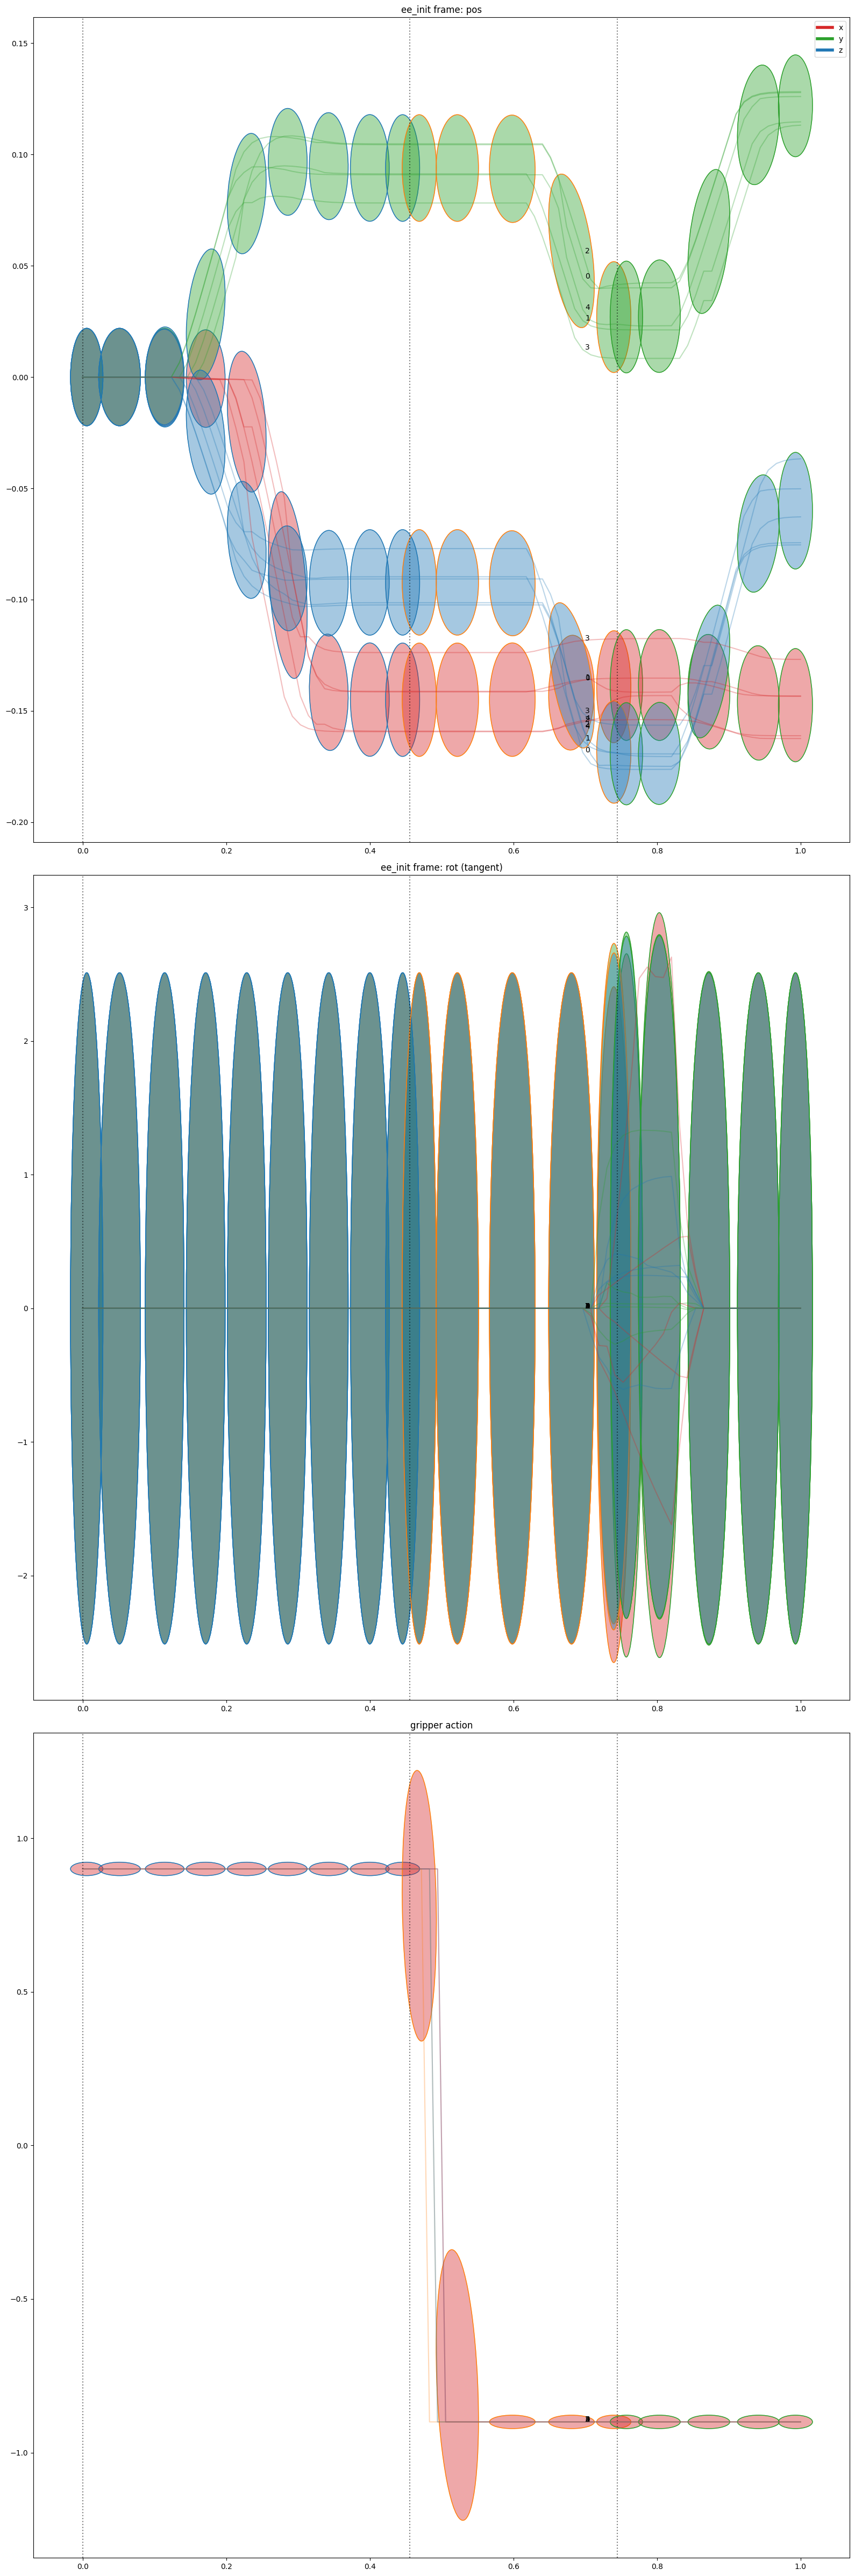

In [64]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [65]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-04-12 17:38:13.333 | INFO     |          Fitting AutoTPGMM


Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[8.48e-001, 7.55e-001, 6.06e-001, ..., 1.10e-093, 1.06e-097,
          9.09e-102],
         [1.52e-001, 2.44e-001, 3.91e-001, ..., 4.83e-055, 3.33e-057,
          2.28e-059],
         [1.36e-004, 6.20e-004, 2.74e-003, ..., 3.50e-047, 2.98e-049,
          2.46e-051],
         ...,
         [1.75e-043, 2.27e-041, 2.85e-039, ..., 2.87e-003, 7.21e-004,
          1.75e-004],
         [4.23e-057, 1.40e-054, 4.51e-052, ..., 3.11e-001, 1.82e-001,
          1.03e-001],
         [6.79e-085, 3.17e-081, 1.37e-077, ..., 6.86e-001, 8.17e-001,
          8.97e-001]]),
  array([[1.00e+00, 9.99e-01, 9.99e-01, 9.99e-01, 6.30e-04, 2.18e-04,
          5.92e-05, 1.25e-05, 2.10e-06, 2.99e-07, 3.68e-08, 4.01e-09,
          3.86e-10, 3.26e-11, 2.36e-12, 1.44e-13, 7.15e-15, 2.32e-16,
          3.60e-18, 4.26e-21, 6.99e-24, 4.09e-27, 8.73e-30, 4.06e-32,
          2.17e-34, 1.15e-36, 1.00e+00, 9.99e-01, 3.34e-03, 1.63e-03,
          6.84e-04, 2.36e-04, 6.39e-05, 1.34e-05, 2.26e-06, 3.20e-07,
          3.

2025-04-12 17:38:15.816 | INFO     |          Did not specify time_based, deciding automatically.


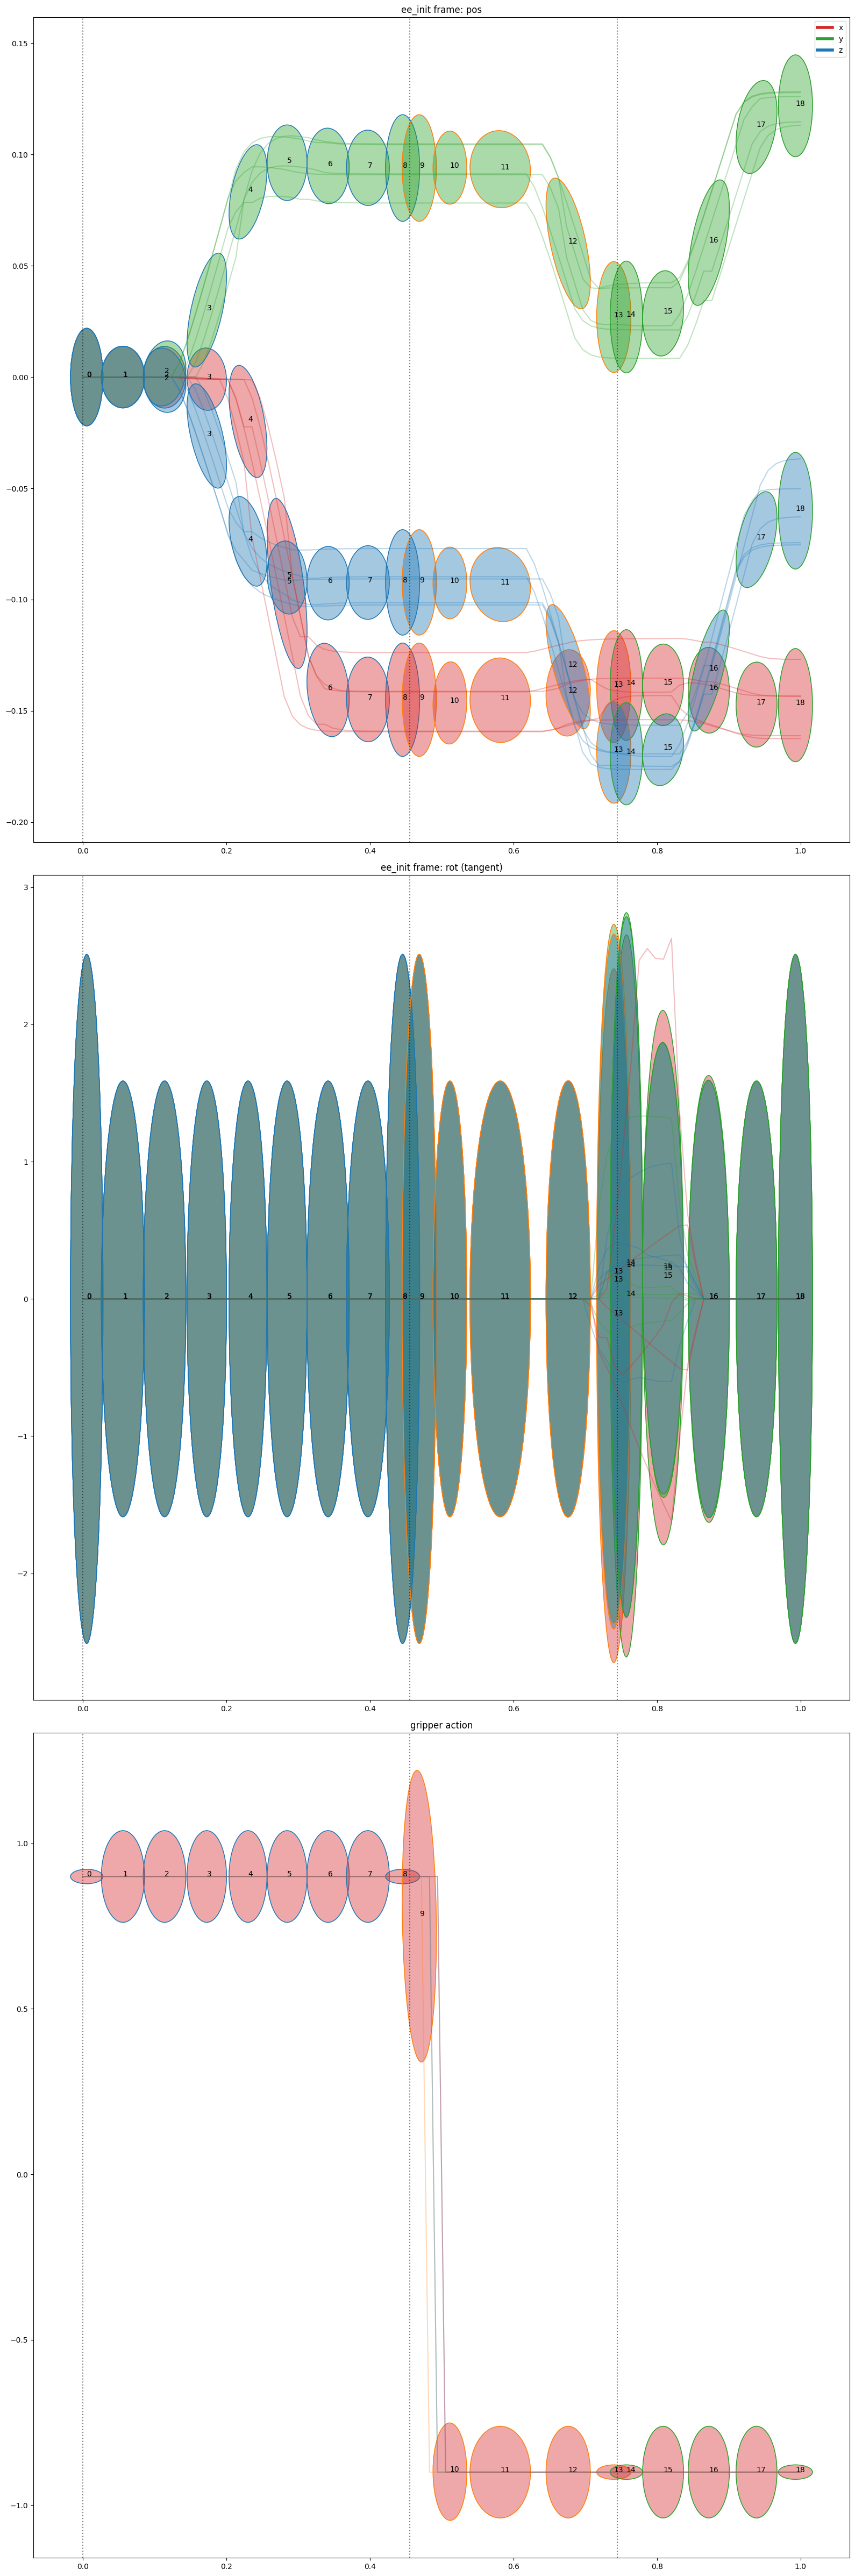

In [66]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

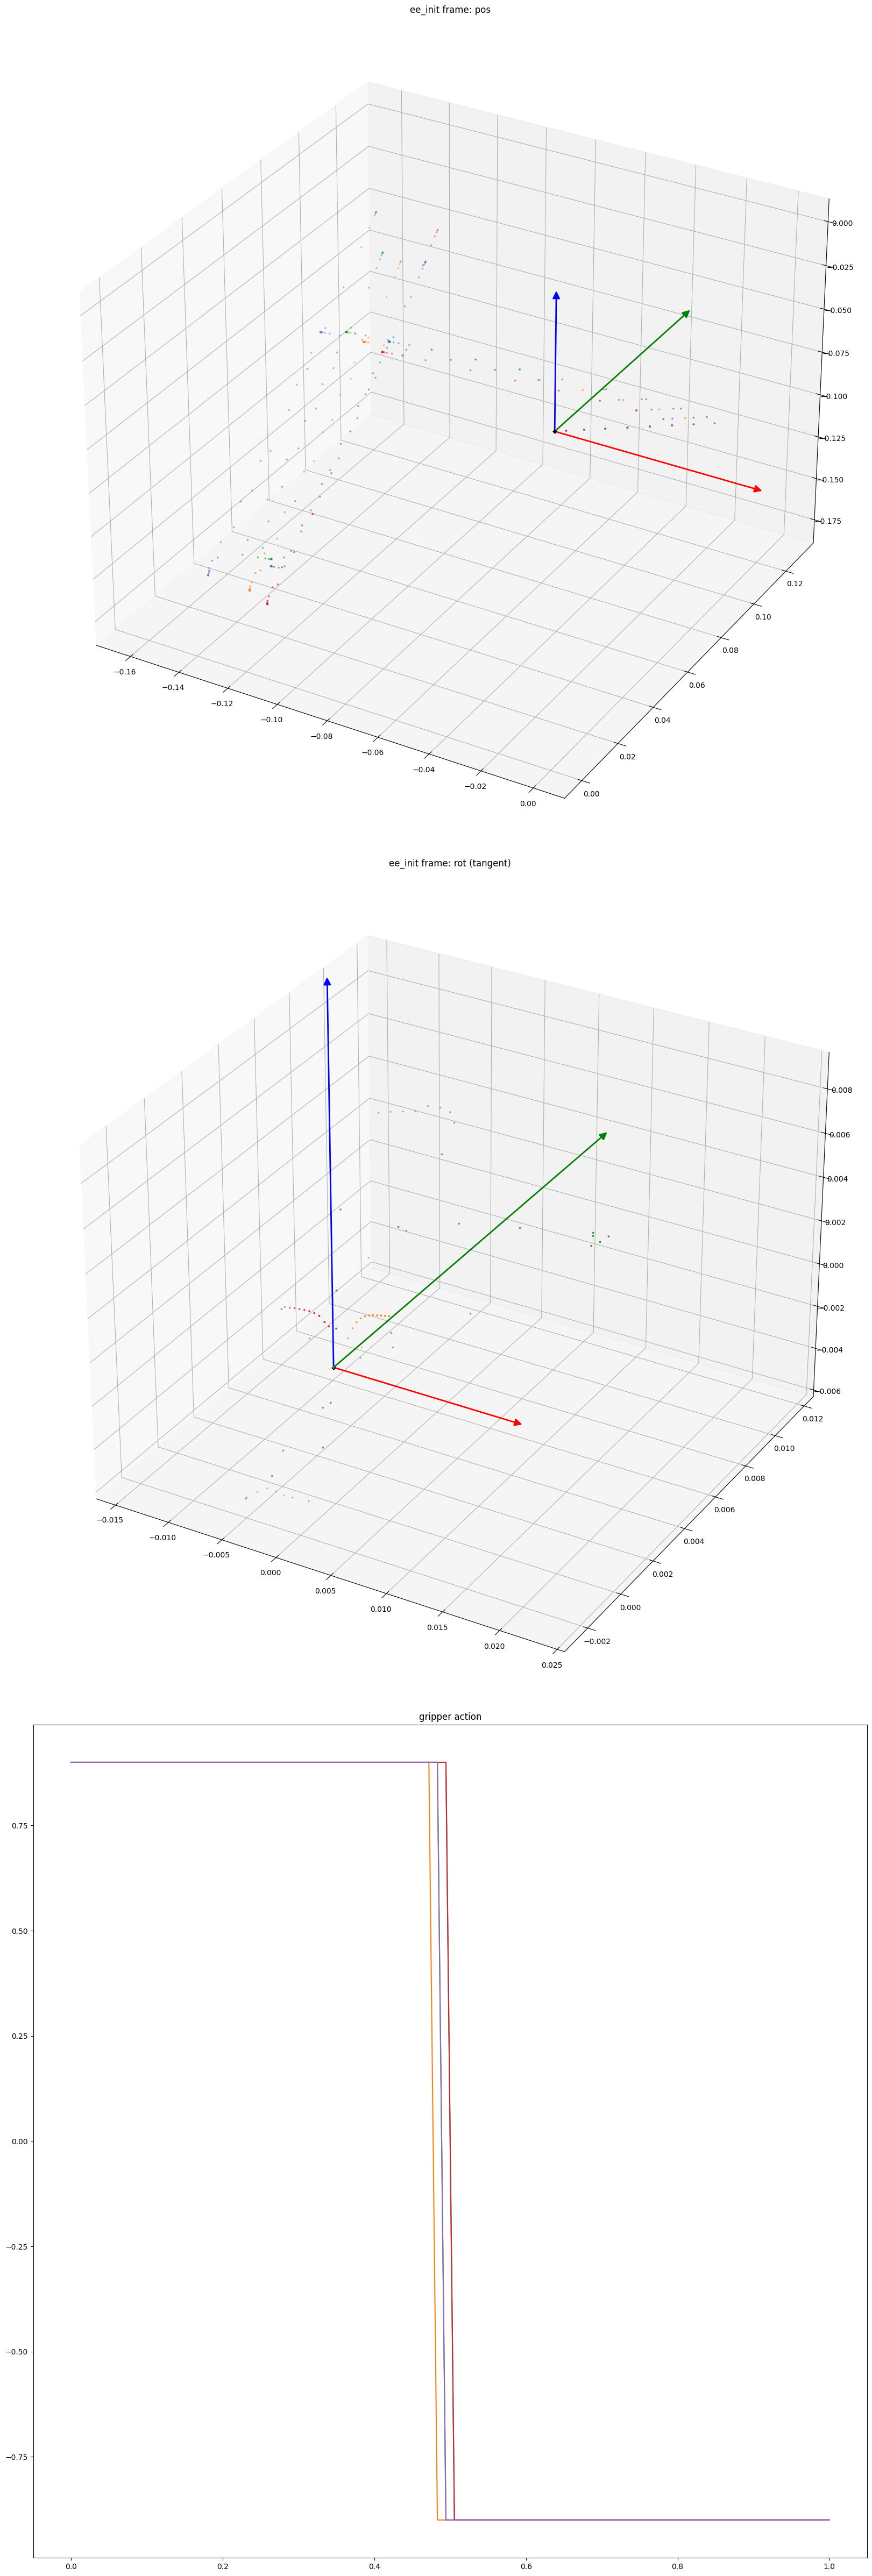

In [67]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

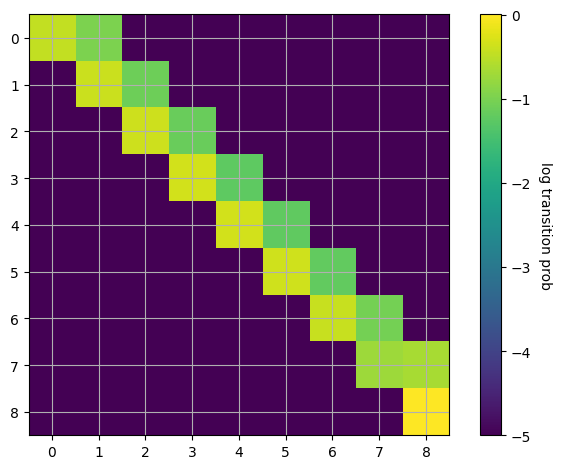

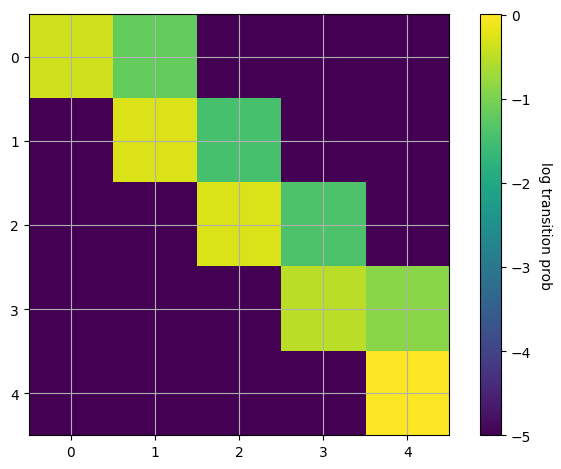

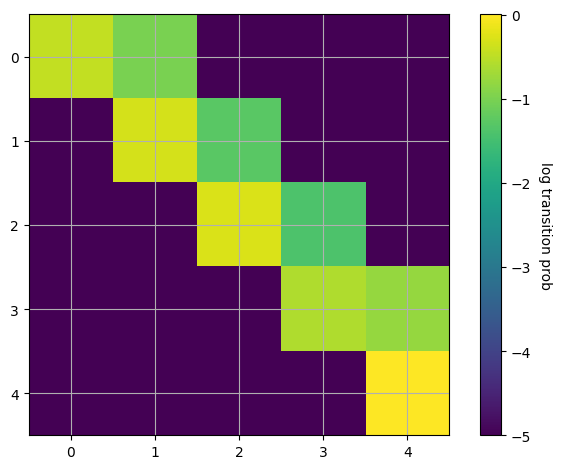

In [68]:
atpgmm.plot_hmm_transition_matrix()

In [69]:
atpgmm.to_disk(data_root / task / f'demos_gmm_policy-{tag}.pt')

In [70]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-04-12 17:38:24.686 | INFO     |          Caculated segment transition probabilities: (array([[1.]]), array([[1.]]))
2025-04-12 17:38:24.686 | INFO     |          Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:24.767 | INFO     |          Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-04-12 17:38:24.833 | INFO     |          Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

GMR:   0%|          | 0/5 [00:00<?, ?it/s]

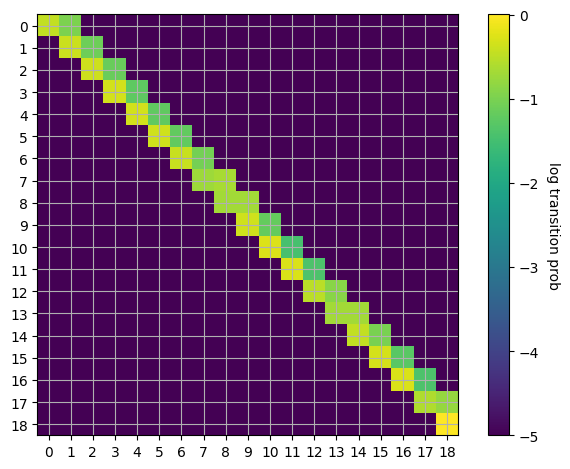

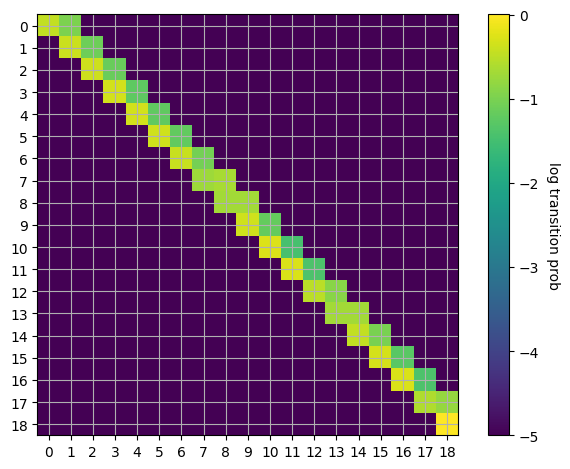

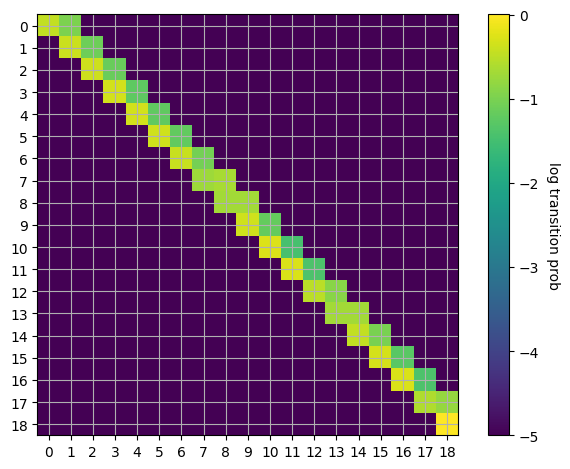

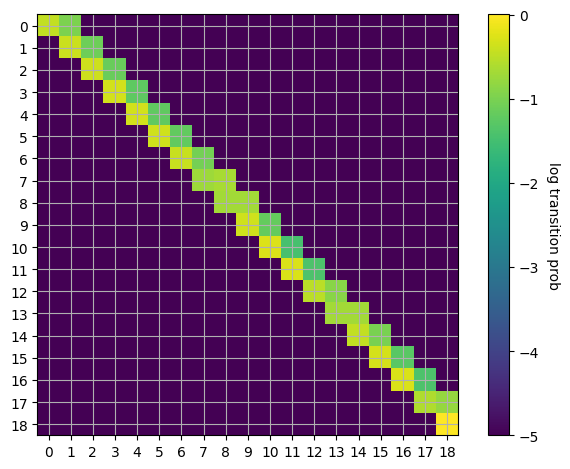

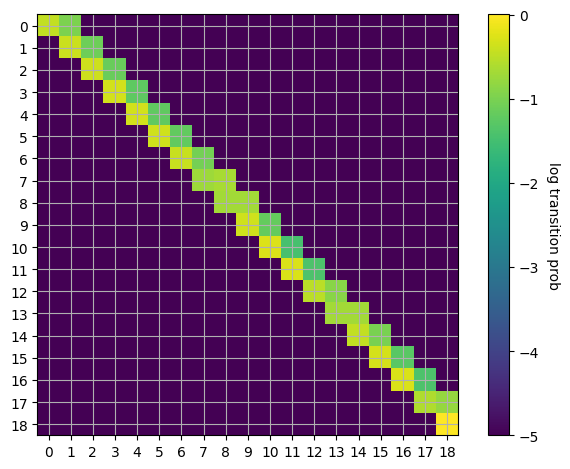

In [71]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-04-12 17:38:46.218 | INFO     |          Taking frame origins from demos.


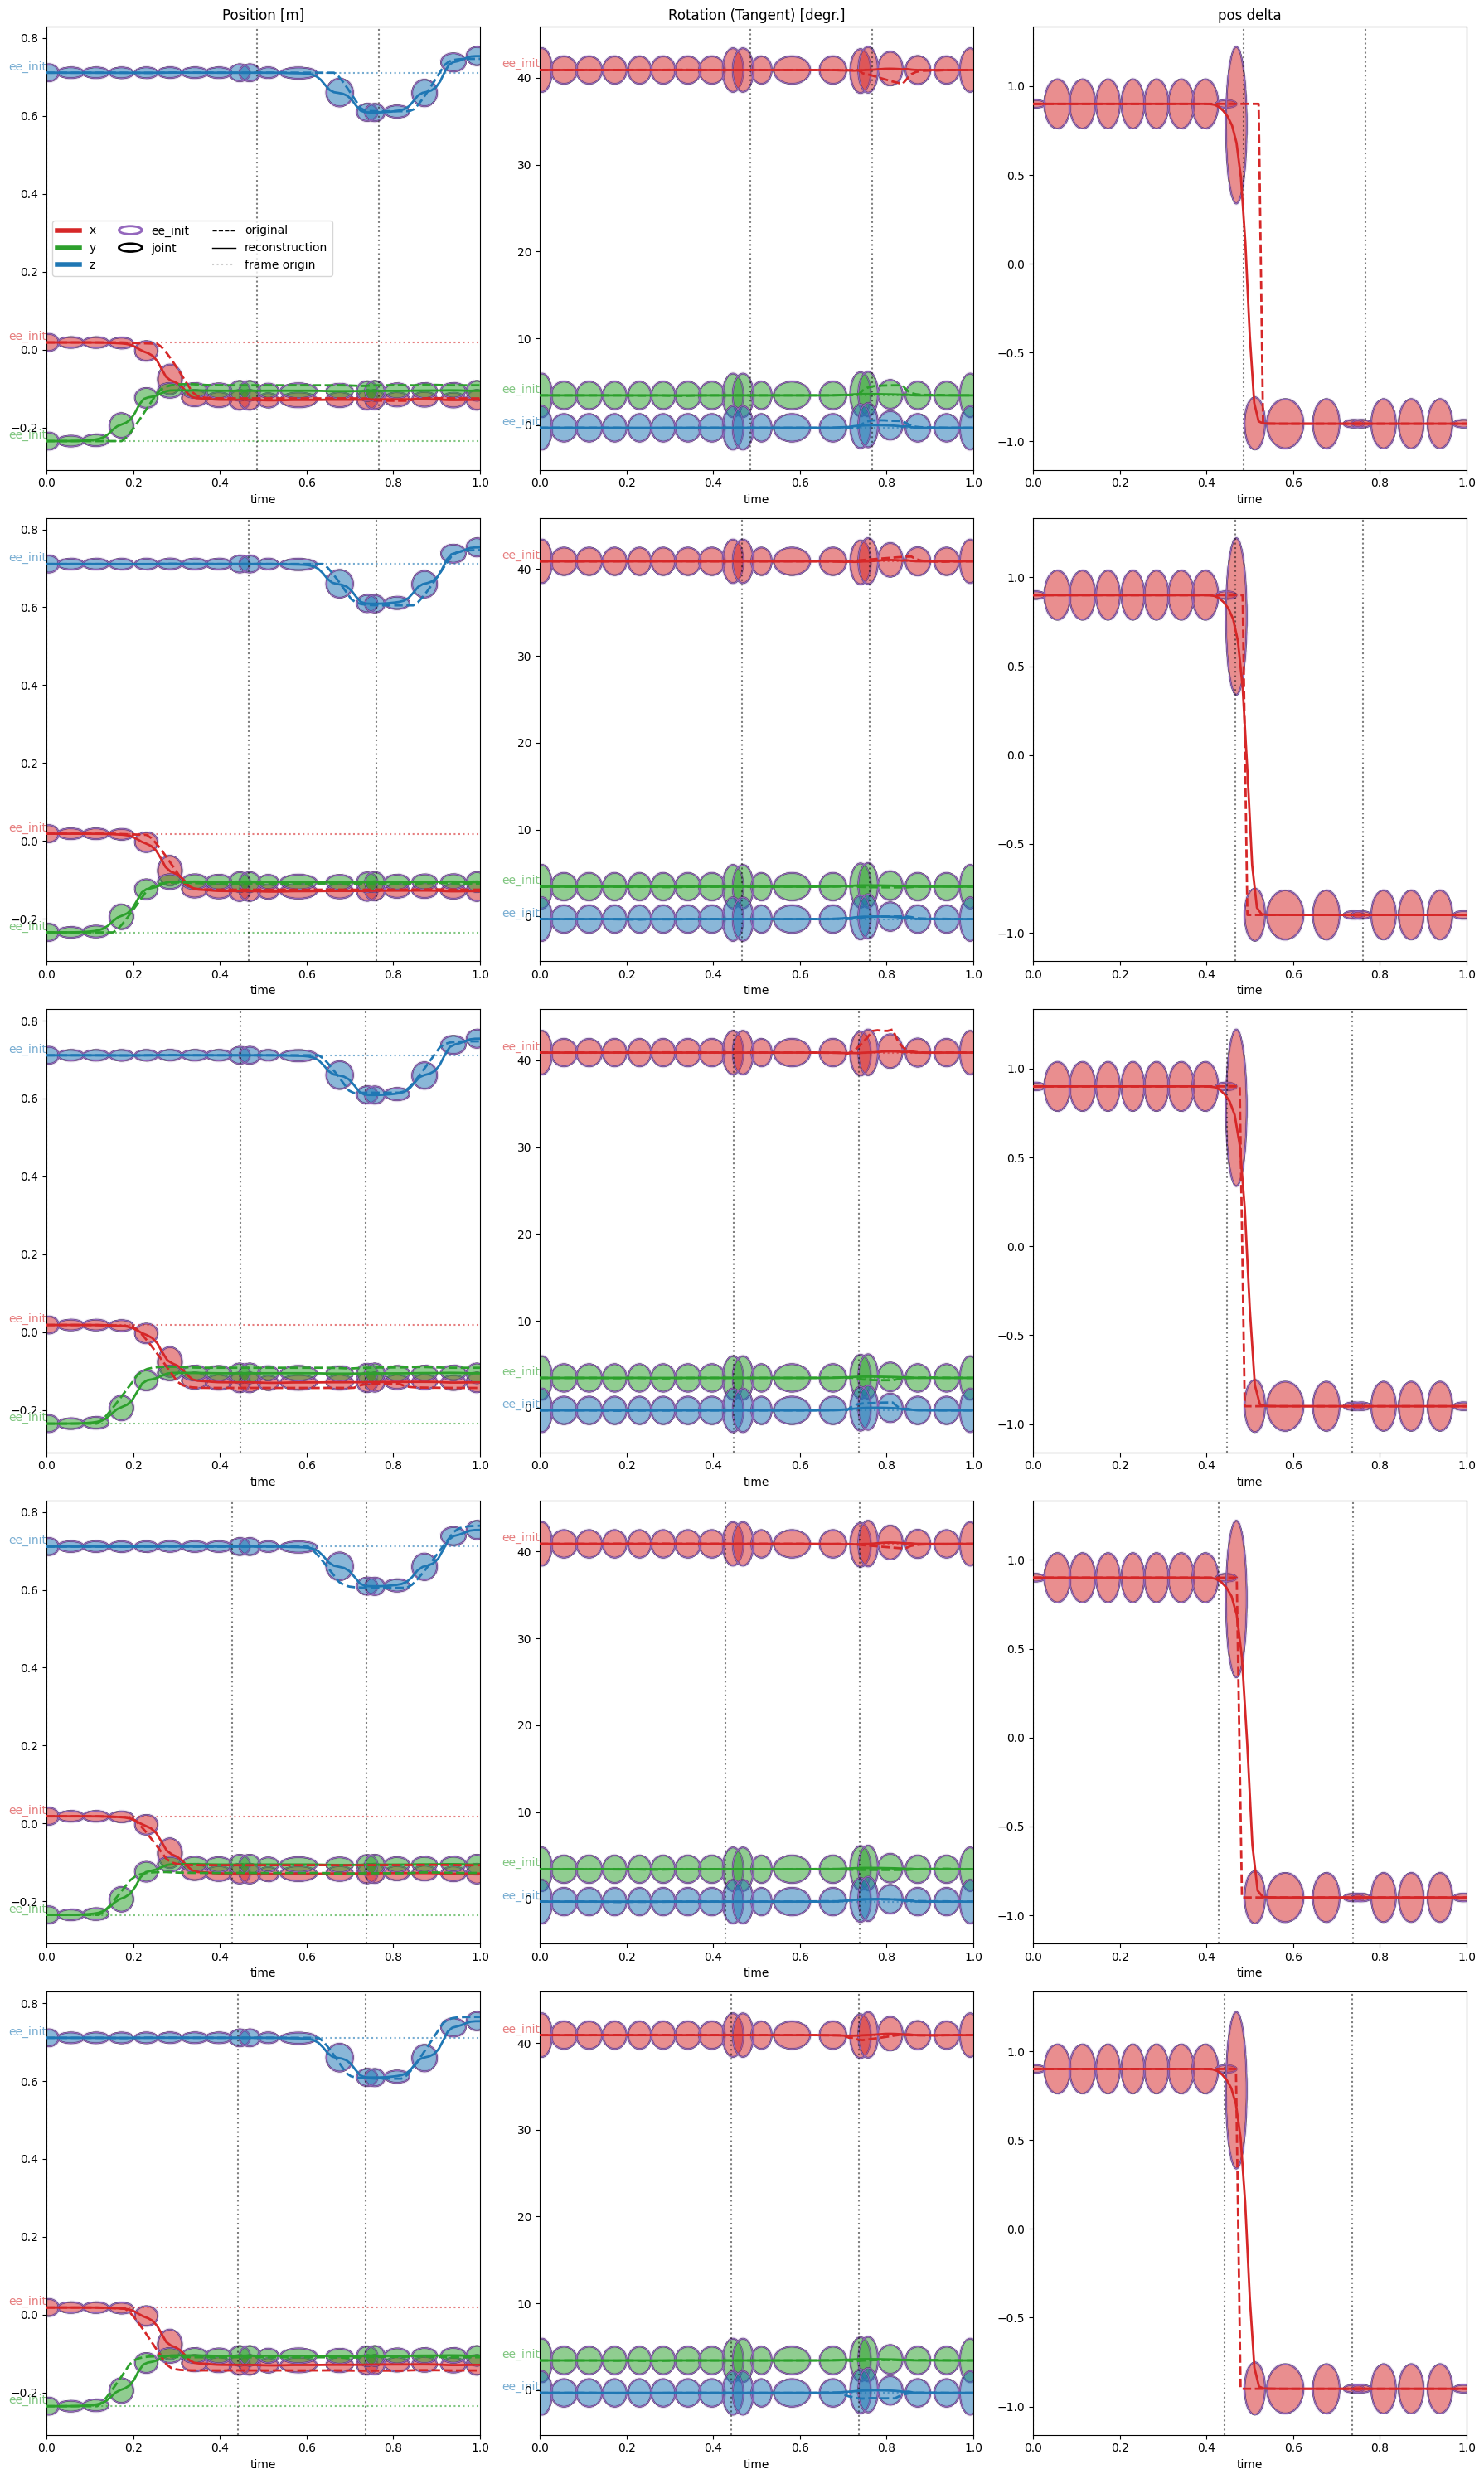

In [72]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container,
    cascaded_hmms,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=False,
    per_segment=False,
)

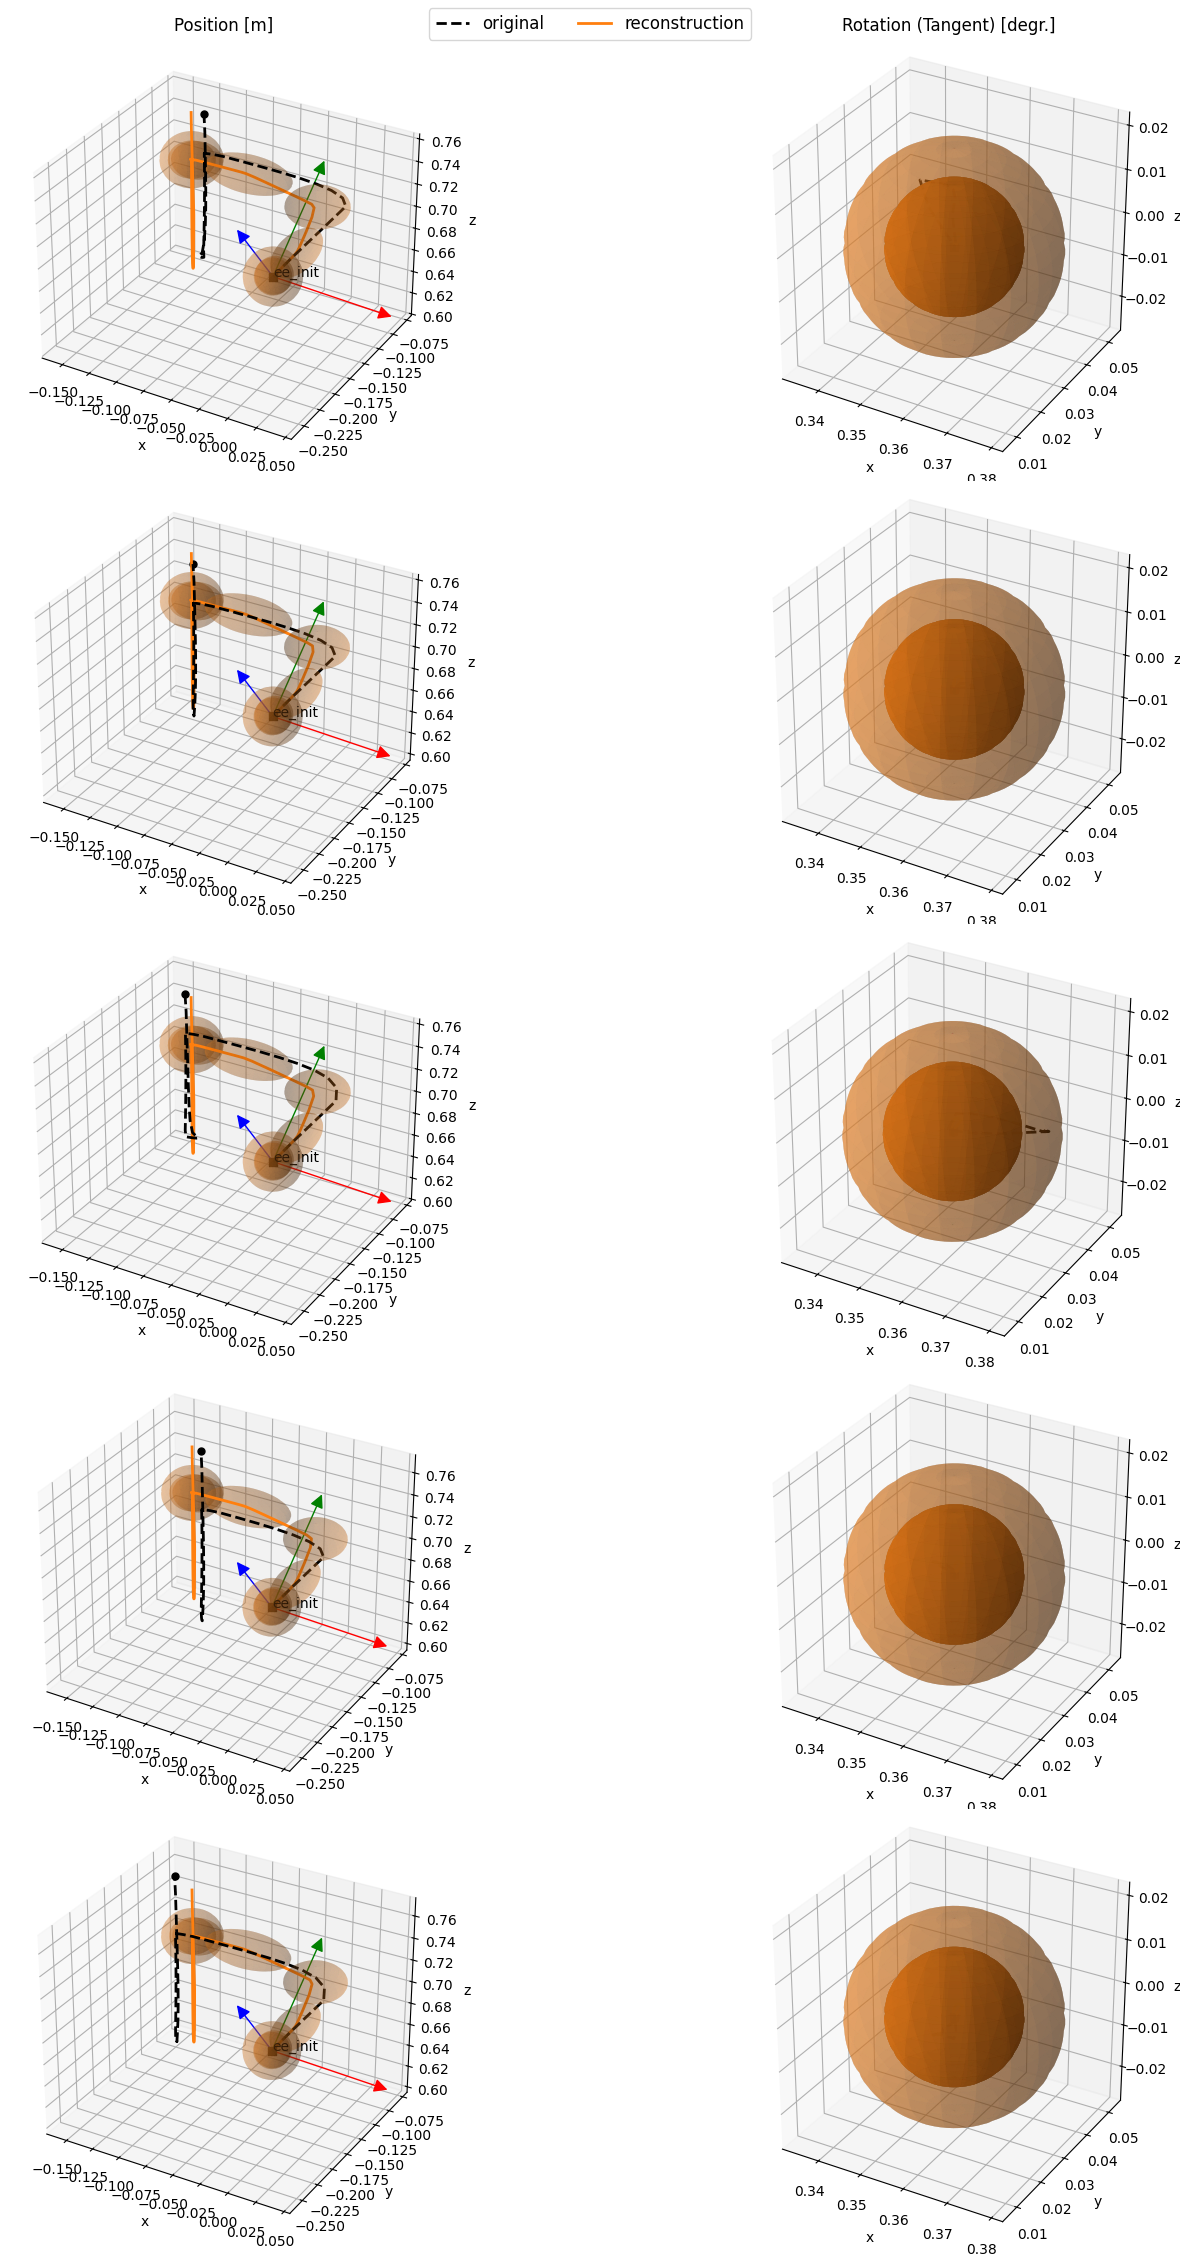

In [73]:
atpgmm.plot_reconstructions(
    seg_trans_marginals,
    seg_joint_models,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=False,
    equal_aspect=True,
    per_segment=False,
)